In [1]:
import os
import cv2
import requests
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
from tqdm.notebook import tqdm
from pprint import pprint
import seaborn as sns

/home/ai/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def dsize(img, new_width=None, new_height=None, interp=cv2.INTER_LINEAR):
    h, w = img.shape[:2]

    if new_width is None and new_height is None:
        return h, w

    if new_width is None:
        ratio = new_height / h
        size = (int(w * ratio), new_height)

    if new_height is None:
        ratio = new_width / w
        size = (new_width, int(h * ratio))

    return size


def random_crop(img, percent=5, shape=(512, 512)):
    if percent < 1:
        return img
    range_x = int(img.shape[1] * (percent / 100))
    range_y = int(img.shape[0] * (percent / 100))

    start_x = np.random.randint(0, range_x)
    start_y = np.random.randint(0, range_y)

    stop_x = img.shape[1] - start_x
    stop_y = img.shape[0] - start_y

    crop = img[start_x:stop_x, start_y:stop_y]

    return crop


def predict(host, port, img):
    img = cv2.imencode('.png', img)[1].tobytes()
    response = requests.post(f'http://{host}:{port}', data=img)
    # print(response.headers)
    img = cv2.imdecode(np.asarray(bytearray(response.content), dtype=np.uint8), cv2.IMREAD_COLOR)
    return img, response.headers

In [3]:
input_path = 'shift/dataset/'
classes = os.listdir(input_path)

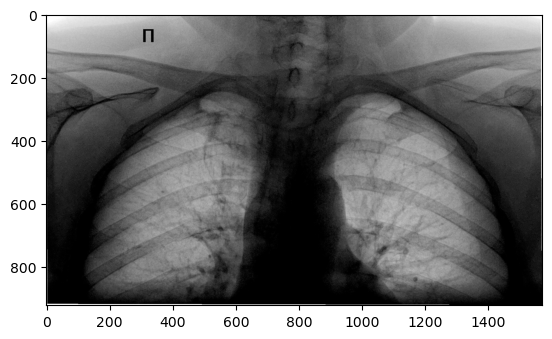

In [15]:
img = cv2.imread('shift/dataset/garbage/1.2.840.113619.2.261.4.2147483647.1642868220.983759.jpg')
img = np.invert(img)
plt.imshow(img)

In [16]:
result, headers = predict(host='192.168.0.62', port=1090, img=img)

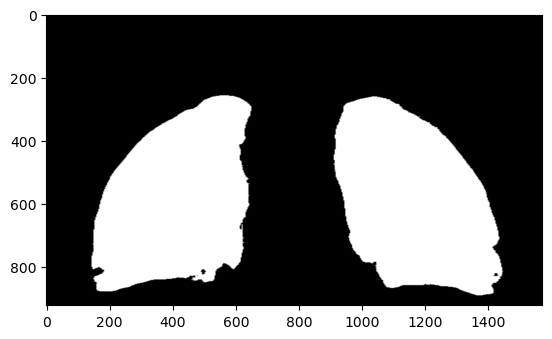

In [17]:
plt.imshow(result)

In [18]:
# res_img = result[30:2470, 30:2470]
# plt.imshow(res_img)

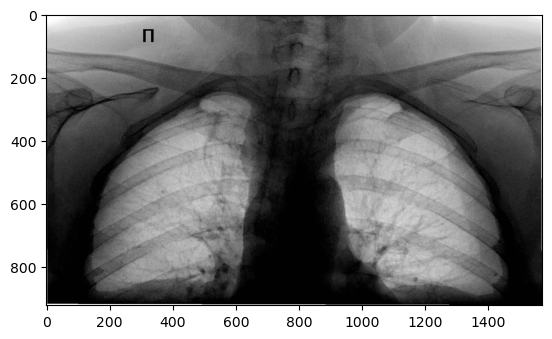

In [19]:
masked = cv2.addWeighted(img, 1, result, 0.1, 1)
plt.imshow(masked)

In [9]:
# дичь
def auc_loss(y_true, y_predicted):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(1):
        fpr[i], tpr[i], _ = roc_curve(y_true, y_predicted)
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    return 1 - roc_auc[0]

In [10]:
shifts = []

In [11]:
y_true = []
y_predicted = []

for cls in tqdm(classes):
    files = os.listdir(f'{input_path}/{cls}')
    for file in tqdm(files):
        if file == '.ipynb_checkpoints':
            continue
        img = cv2.imread(f'{input_path}/{cls}/{file}')
        img = cv2.bitwise_not(img)

        crop = random_crop(img, percent=0)

        testing_img, headers = predict(host='192.168.0.62', port=1090, img=crop)
        testing_merged = cv2.addWeighted(crop, 1.0, testing_img, 0.3, 1.0)
        

        height = testing_img.shape[0]
        width = testing_img.shape[1]

        right_top_edge = np.sum(testing_img[:height // 2, -1, 0] > 10) / height * 100
        left_top_edge = np.sum(testing_img[:height // 2, 0, 0] > 10) / height * 100
        right_bottom_edge = np.sum(testing_img[height // 2:, -1, 0] > 10) / height * 100
        left_bottom_edge = np.sum(testing_img[height // 2:, 0, 0] > 10) / height * 100
        top_edge = np.sum(testing_img[0, :, 0] > 10) / width * 100
        bottom_edge = np.sum(testing_img[-1, :, 0] > 10) / width * 100

        intersection = {'top': top_edge,
                        'right': {
                            'right_bottom': right_bottom_edge,
                            'right_top': right_top_edge
                            },
                        'left': {
                            'left_top': left_top_edge,
                            'left_bottom': left_bottom_edge
                            },
                        'bottom': bottom_edge,
                        }

        # print("\n")
        # pprint(intersection, width=20)

        x = np.array([right_top_edge, left_top_edge, right_bottom_edge, left_bottom_edge, top_edge, bottom_edge])
        w = np.array([1, 1, 1, 1, 1, 1], dtype=np.float32)
        threshold = 5
        total_shift_percent = np.dot(x, w.T)
        pred = 0 if total_shift_percent > threshold else 1
        y_true.append(1 if cls == 'normal' else 0)
        y_predicted.append(pred)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

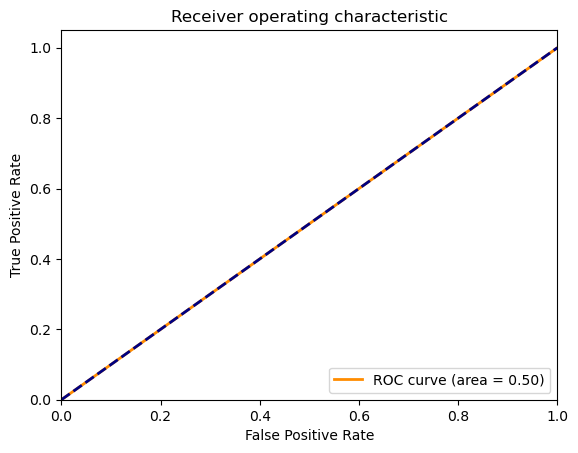

In [12]:
labels = ['normal', 'garbage']

conf_mat = confusion_matrix(y_true, y_predicted)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(1):
    fpr[i], tpr[i], _ = roc_curve(y_true, y_predicted)
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true, y_predicted)
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
plt.figure()
lw = 2
plt.plot(
    fpr[0],
    tpr[0],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[0],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.savefig('auc.png')
plt.show()

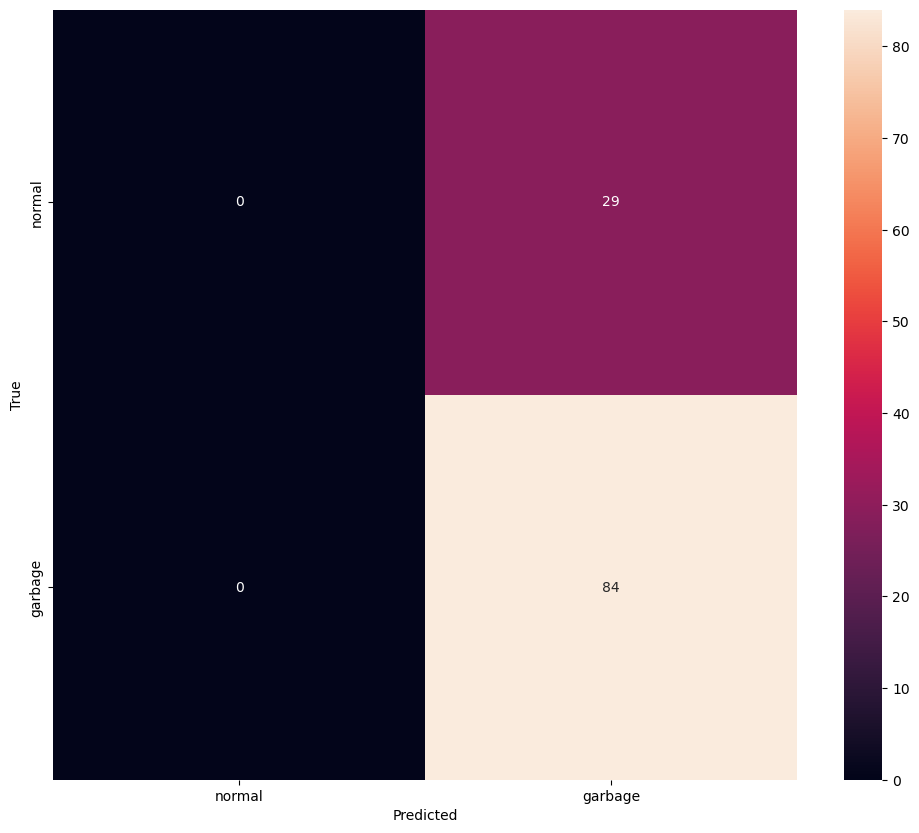

In [13]:
plt.figure(figsize = (12,10))
sns.heatmap(conf_mat, annot=True, xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('conf_matrix.png')